In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [3]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Download Images of Birds and Non-Birds

In [4]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('apple photos', max_images=1)
urls[0]

Searching for 'apple photos'


'https://www.farmersalmanac.com/wp-content/uploads/2020/11/Adocortland_apples-as225320764.jpeg'

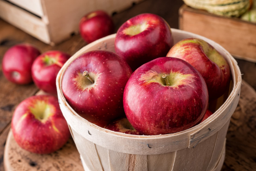

In [6]:
from fastdownload import download_url
dest = 'apple.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'orange photos'


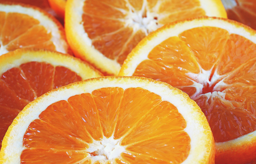

In [7]:
download_url(search_images('orange photos', max_images=1)[0], 'orange.jpg', show_progress=False)
Image.open('orange.jpg').to_thumb(256,256)

In [8]:
searches = 'apple','orange'
path = Path('apple_or_orange')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} rotten photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} fresh photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'apple photo'


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Searching for 'apple rotten photo'
Searching for 'apple fresh photo'
Searching for 'orange photo'
Searching for 'orange rotten photo'
Searching for 'orange fresh photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Train Our Model

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

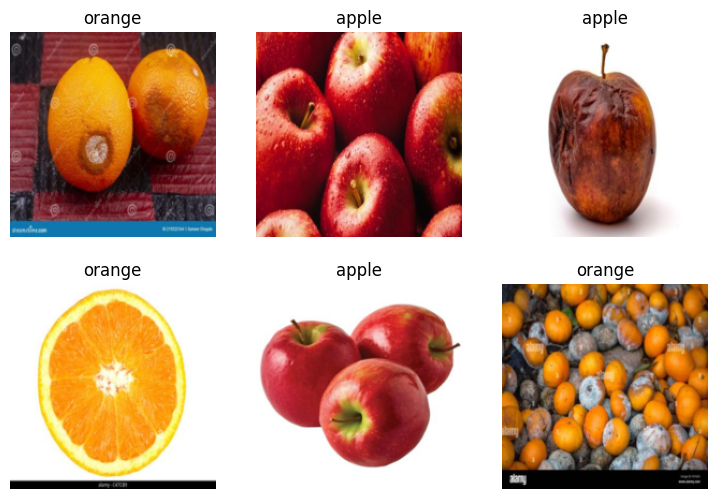

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.8MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.166158,1.831214,0.466667,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.581184,0.657800,0.333333,00:13
1,0.495210,0.143673,0.066667,00:12
2,0.357300,0.071115,0.033333,00:13


## Predicting the Apple

In [12]:
is_apple,_,probs = learn.predict(PILImage.create('apple.jpg'))
print(f"This is a: {is_apple}.")
print(f"Probability it's a apple: {probs[0]:.4f}")

This is a: apple.
Probability it's a apple: 1.0000
